In [1]:
#Spacy org
#!pip install spacy
#!python3 -m spacy download en_core_web_sm
#!python3 -m spacy download en_core_web_md
#!python3 -m spacy download en_core_web_lg

# NER Entity Notebook

* Telehealth NER analysis
* Indentify which documents each Entity belongs to
* Compare Pre-Covid and Post Covid Entity identification concerning Organizations and People

* <b> Classification = "Pre-Covid" and "Covid"<b>

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import yellowbrick

parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
             'xtick.labelsize':20,
             "figure.figsize" : (20, 10)
             }


plt.rcParams.update(parameters)

df_overview = pd.read_csv("./Data/processed/Telehealth.csv")

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import spacy

corpus = df_overview["Content"]

nlp = spacy.load("en_core_web_sm")

docs = list(nlp.pipe(corpus,disable=["parser","textcat"]))

In [4]:
#Gather the Entity labels from Spacy

ner_dictionary = dict()

ner_dictionary_count = dict()

ner_dictionary_document = dict()

#NER token with label
for index, doc in enumerate(docs):
    
    for ent in doc.ents:

        ner_dictionary[ent.text] = ent.label_

        #ner_dictionary_document[ent.text]  (ent.text,index)

        if ent.text in ner_dictionary_count.keys():
            ner_dictionary_count[ent.text] += 1
            ner_dictionary_document[ent.text].add(str(index))

        else:
            ner_dictionary_count[ent.text] = 1
            ner_dictionary_document[ent.text] = {str(index)}

In [5]:
ner_data = [ner_dictionary,ner_dictionary_count,ner_dictionary_document]
df_ner = (pd.DataFrame(ner_data)
          .T
          .reset_index()
          .rename(columns={"index":"Term",0:"NER_Label",1:"Count",2:"Document"})
         .sort_values(by="Count",ascending=False))

In [6]:
df_ner.head(5)

Term NER_Label Count                                           Document
3061   TMH       ORG   293                           {35, 33, 36, 38, 32, 31}
154   2020      DATE   271  {30, 33, 13, 15, 1, 9, 34, 3, 8, 12, 19, 32, 7...
22    2013      DATE   236  {33, 13, 17, 37, 15, 20, 39, 41, 1, 23, 9, 34,...
30    2018      DATE   233  {33, 13, 17, 15, 20, 1, 23, 9, 34, 3, 22, 8, 1...
34    2015      DATE   231  {30, 17, 37, 15, 20, 39, 41, 1, 34, 36, 3, 22,...

In [7]:
#Load abrv dictionary to add long form.  This dictionary comes from the Wrangling notebook

with open("./references/abbreviation_table_processed.json", "r") as r:
    
    abrv_dict = json.load(r)


In [8]:
df_ner["Long_Form"] = df_ner["Term"].apply(lambda x: abrv_dict[x]["LongForm"] if x in abrv_dict.keys() else x)

df_ner.head(5)

Term NER_Label Count                                           Document  \
3061   TMH       ORG   293                           {35, 33, 36, 38, 32, 31}   
154   2020      DATE   271  {30, 33, 13, 15, 1, 9, 34, 3, 8, 12, 19, 32, 7...   
22    2013      DATE   236  {33, 13, 17, 37, 15, 20, 39, 41, 1, 23, 9, 34,...   
30    2018      DATE   233  {33, 13, 17, 15, 20, 1, 23, 9, 34, 3, 22, 8, 1...   
34    2015      DATE   231  {30, 17, 37, 15, 20, 39, 41, 1, 34, 36, 3, 22,...   

              Long_Form  
3061  telemental health  
154                2020  
22                 2013  
30                 2018  
34                 2015

# Modify NER Classification

In [9]:
df_ner[df_ner["Term"] == "Zoom"]

Term NER_Label Count                   Document Long_Form
632  Zoom    PERSON    17  {4, 2, 11, 17, 32, 15, 5}      Zoom

In [10]:
#Change Zoom from PERSON to ORG 
df_ner.at[632,"NER_Label"] = "ORG"

In [11]:
#Validation
df_ner[df_ner["Term"] == "Zoom"]

Term NER_Label Count                   Document Long_Form
632  Zoom       ORG    17  {4, 2, 11, 17, 32, 15, 5}      Zoom

In [12]:
#Enable each term to be paired with the respective document to assign term to Classification
df_ner_exploded = df_ner.explode('Document').astype({"Document":"int64"}).drop(columns="Count")
df_ner_exploded.head()

Term NER_Label  Document          Long_Form
3061  TMH       ORG        35  telemental health
3061  TMH       ORG        33  telemental health
3061  TMH       ORG        36  telemental health
3061  TMH       ORG        38  telemental health
3061  TMH       ORG        32  telemental health

In [13]:
entity_by_document_overview = df_ner_exploded.merge(df_overview,left_on="Document",right_on=df_overview.index)

In [14]:
#Classification is the last column
entity_by_document_overview.head()

Term NER_Label  Document          Long_Form  \
0   TMH       ORG        35  telemental health   
1  2013      DATE        35               2013   
2  2018      DATE        35               2018   
3  2015      DATE        35               2015   
4  2014      DATE        35               2014   

                    Journal Title  \
0  Journal of Rural Mental Health   
1  Journal of Rural Mental Health   
2  Journal of Rural Mental Health   
3  Journal of Rural Mental Health   
4  Journal of Rural Mental Health   

                                       Article Title  Date Published  \
0  Barriers and Facilitators to Implementing a U....            2020   
1  Barriers and Facilitators to Implementing a U....            2020   
2  Barriers and Facilitators to Implementing a U....            2020   
3  Barriers and Facilitators to Implementing a U....            2020   
4  Barriers and Facilitators to Implementing a U....            2020   

                                             Authors  \
0  Erica Shreck; Nicole Nehrig; Jennifer A. Schne...   
1  Erica Shreck; Nicole Nehrig; Jennifer A. Schne...   
2  Erica Shreck; Nicole Nehrig; Jennifer A. Schne...   
3  Erica Shreck; Nicole Nehrig; Jennifer A. Schne...   
4  Erica Shreck; Nicole Nehrig; Jennifer A. Schne...   

                                            Abstract  \
0  Telemental health refers to the use of informa...   
1  Telemental health refers to the use of informa...   
2  Telemental health refers to the use of informa...   
3  Telemental health refers to the use of informa...   
4  Telemental health refers to the use of informa...   

                                            Keywords  ...  \
0  KEYWORDS:\n\ntelemental health, Veterans, remo...  ...   
1  KEYWORDS:\n\ntelemental health, Veterans, remo...  ...   
2  KEYWORDS:\n\ntelemental health, Veterans, remo...  ...   
3  KEYWORDS:\n\ntelemental health, Veterans, remo...  ...   
4  KEYWORDS:\n\ntelemental health, Veterans, remo...  ...   

                                             Content Content_Length  \
0  Telemental health (TMH) refers to the use of i...          42895   
1  Telemental health (TMH) refers to the use of i...          42895   
2  Telemental health (TMH) refers to the use of i...          42895   
3  Telemental health (TMH) refers to the use of i...          42895   
4  Telemental health (TMH) refers to the use of i...          42895   

   Abstract_Length                                    Parsed_Keywords  \
0             1704  ['telemental', 'health,', 'Veterans,', 'remote...   
1             1704  ['telemental', 'health,', 'Veterans,', 'remote...   
2             1704  ['telemental', 'health,', 'Veterans,', 'remote...   
3             1704  ['telemental', 'health,', 'Veterans,', 'remote...   
4             1704  ['telemental', 'health,', 'Veterans,', 'remote...   

  Parsed_Keywords_Length                          Subfield et_al_Count  \
0                      9  Clinical & Counseling Psychology          11   
1                      9  Clinical & Counseling Psychology          11   
2                      9  Clinical & Counseling Psychology          11   
3                      9  Clinical & Counseling Psychology          11   
4                      9  Clinical & Counseling Psychology          11   

              Stopwords_Lemma_Longform_Clean_Content  \
0  telemental health telemental health refer use ...   
1  telemental health telemental health refer use ...   
2  telemental health telemental health refer use ...   
3  telemental health telemental health refer use ...   
4  telemental health telemental health refer use ...   

                                       Clean_Content Classification  
0  telemental health telemental health refer use ...          Covid  
1  telemental health telemental health refer use ...          Covid  
2  telemental health telemental health refer use ...          Covid  
3  telemental health telemental health refer use ...          Covid  
4  tele

# Plot Overall Entities Labels

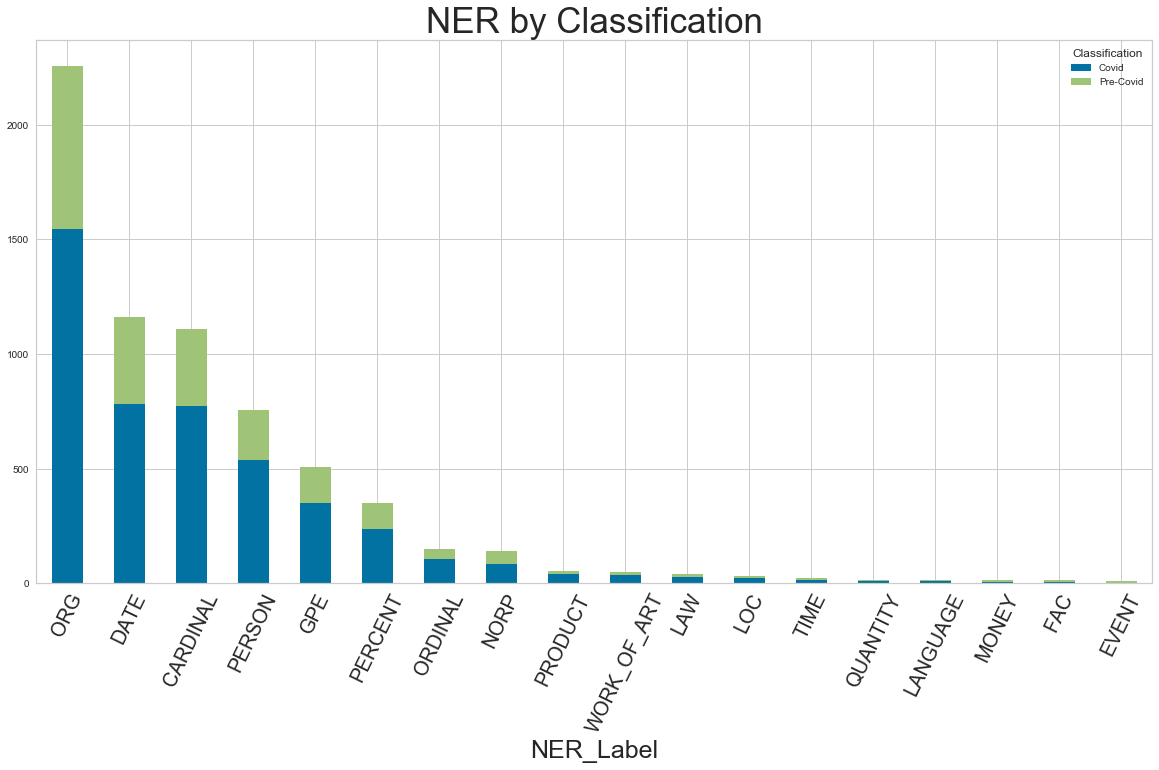

In [15]:
ner_overview_plot = (entity_by_document_overview.groupby(['Classification', 'NER_Label']).size().reset_index()
           .pivot(columns='Classification', index='NER_Label', values=0)
           .sort_values(by="Covid",ascending=False))

ner_overview_plot.plot(kind='bar', stacked=True,title="NER by Classification")
_ = plt.xticks(rotation=64)

# Top 10 of ORG and Person since they have the highest identifications

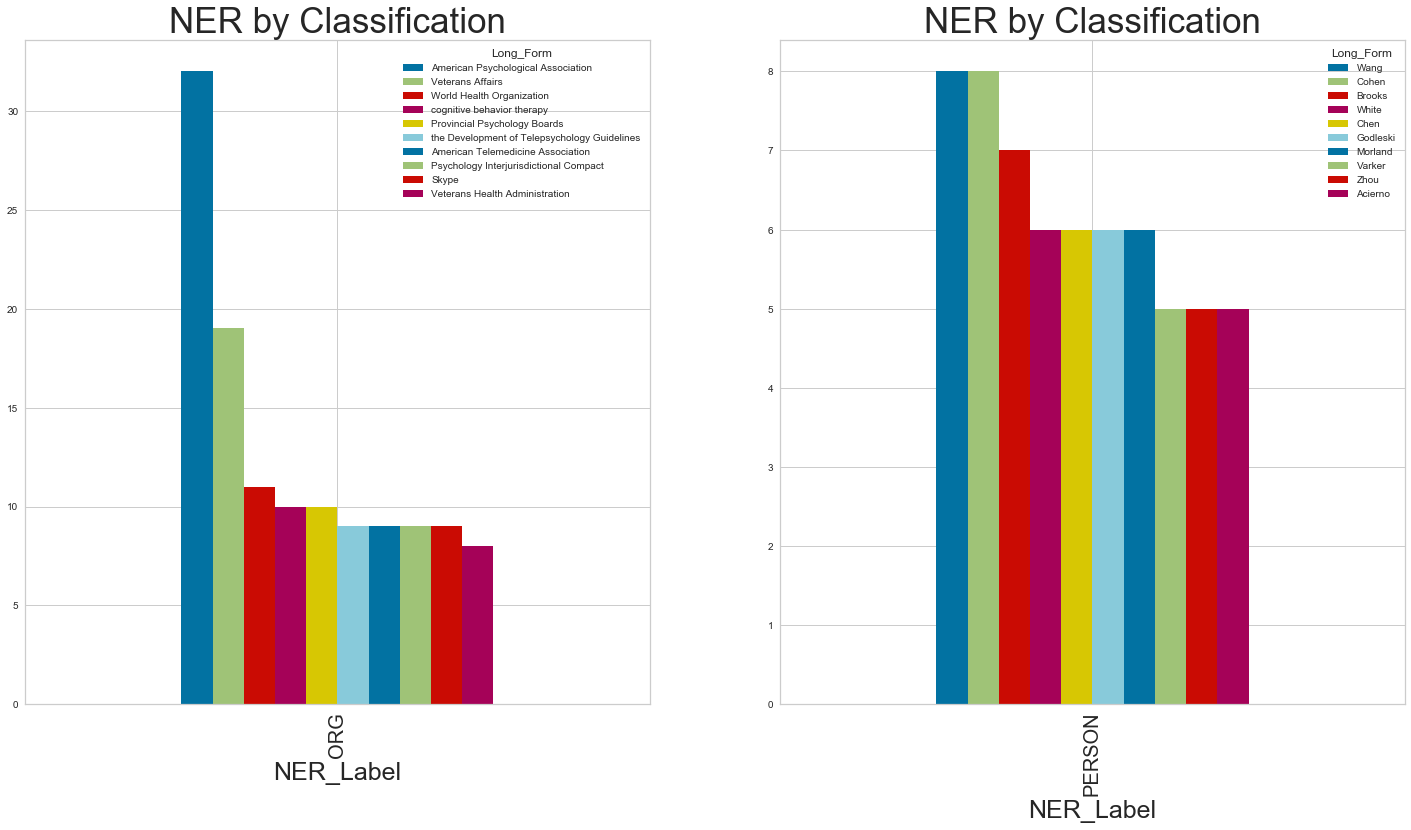

In [16]:
top = 10

visualize_cols = ["ORG","PERSON"]

fig, ax = plt.subplots(1,len(visualize_cols))
fig.tight_layout(h_pad=2,w_pad=8)

for index,col in enumerate(visualize_cols):

    dataset = entity_by_document_overview.query(f'NER_Label == "{col}"')

    ner_overview_plot = (dataset.groupby(['Long_Form', 'NER_Label']).size().reset_index()
                         
                .pivot(columns='NER_Label', index='Long_Form', values=0)
                         
                 .sort_values(by=col,ascending=False)
                         
                 .head(top)
                .T
                )

    ner_overview_plot.plot(kind='bar',title="NER by Classification",ax=ax[index])

# Filter datasets for comparison

In [17]:
pre_covid = (entity_by_document_overview
             .query('Classification == "Pre-Covid" & (NER_Label == "ORG" |NER_Label == "PERSON")'))


pre_covid_plot = (pre_covid[["NER_Label","Long_Form","Term","Document"]]
                  .groupby(["NER_Label","Long_Form"])
                  .count()
                  .sort_values(by="Document",ascending=False)
                  .rename(columns={"Document":"Pre-Covid"})
                  .reset_index()
                 
                 
                 )

In [18]:
pre_covid_plot["Classification"] = "Pre-Covid"
pre_covid_plot.head()

NER_Label                               Long_Form  Term  Pre-Covid  \
0       ORG      American Psychological Association     8          8   
1       ORG                        Veterans Affairs     6          6   
2       ORG  Psychology Interjurisdictional Compact     4          4   
3    PERSON                                  Kramer     3          3   
4       ORG                                   Apple     3          3   

  Classification  
0      Pre-Covid  
1      Pre-Covid  
2      Pre-Covid  
3      Pre-Covid  
4      Pre-Covid

In [19]:
post_covid = (entity_by_document_overview
              .query('Classification == "Covid" & (NER_Label == "ORG" |NER_Label == "PERSON")'))


post_covid_plot = (post_covid[["NER_Label","Long_Form","Term","Document"]]
                  .groupby(["NER_Label","Long_Form"])
                  .count()
                  .sort_values(by="Document",ascending=False)
                  .rename(columns={"Document":"Covid"})
                  .reset_index()
                 
                 
                 )

In [20]:
post_covid_plot["Classification"] = "Covid"
post_covid_plot.head()

NER_Label                                     Long_Form  Term  Covid  \
0       ORG            American Psychological Association    24     24   
1       ORG                              Veterans Affairs    13     13   
2       ORG                     World Health Organization     9      9   
3       ORG  the Development of Telepsychology Guidelines     8      8   
4       ORG                              Joint Task Force     7      7   

  Classification  
0          Covid  
1          Covid  
2          Covid  
3          Covid  
4          Covid

In [21]:
plot_by_time = pd.concat([post_covid_plot,pre_covid_plot]).fillna(0)

In [22]:
plot_by_time.head()

NER_Label                                     Long_Form  Term  Covid  \
0       ORG            American Psychological Association    24   24.0   
1       ORG                              Veterans Affairs    13   13.0   
2       ORG                     World Health Organization     9    9.0   
3       ORG  the Development of Telepsychology Guidelines     8    8.0   
4       ORG                              Joint Task Force     7    7.0   

  Classification  Pre-Covid  
0          Covid        0.0  
1          Covid        0.0  
2          Covid        0.0  
3          Covid        0.0  
4          Covid        0.0

# NER ORG Comparison

In [23]:
def plot_compare(data,ner_kind):

    plot_by_time = data[data["NER_Label"] == ner_kind]
    
    times = ["Pre-Covid","Covid"]

    for index,time in enumerate(times):

        combine_plot = (plot_by_time.groupby("Long_Form").sum()
                        .sort_values(by=time,ascending=False)
                        .rename(columns={"Term":"Total_Count"})
                        .drop(columns="Total_Count")
                        .head(10))

        ax = (combine_plot[combine_plot.columns[::-1]]
                 .head(10)
                 .plot(kind="barh",stacked=True,title=f"{time} - NER_Label - {ner_kind}"))
        
        plt.gca().invert_yaxis()

# Take aways
<b> Same <b>
* APA has been a major entity regaruding Telehealth in Psychology
* The VA is a major entity in Telehealth
    
<b> Noticeable Movements <b>
    
<b> Rise <b>
* The term cognitive behavior therapy is on the rise
* The World Health Organization's mentions are on the rise
* Joint Task Forces mentions are on the rise
* Zoom's mentions are on the rise
    
<b> Fall <b>
* Skype is still being discussed, however Zoom has almost the same mentions as Skype
* Apple was mentioned Pre-Covid, but didn't receive a mention during Covid

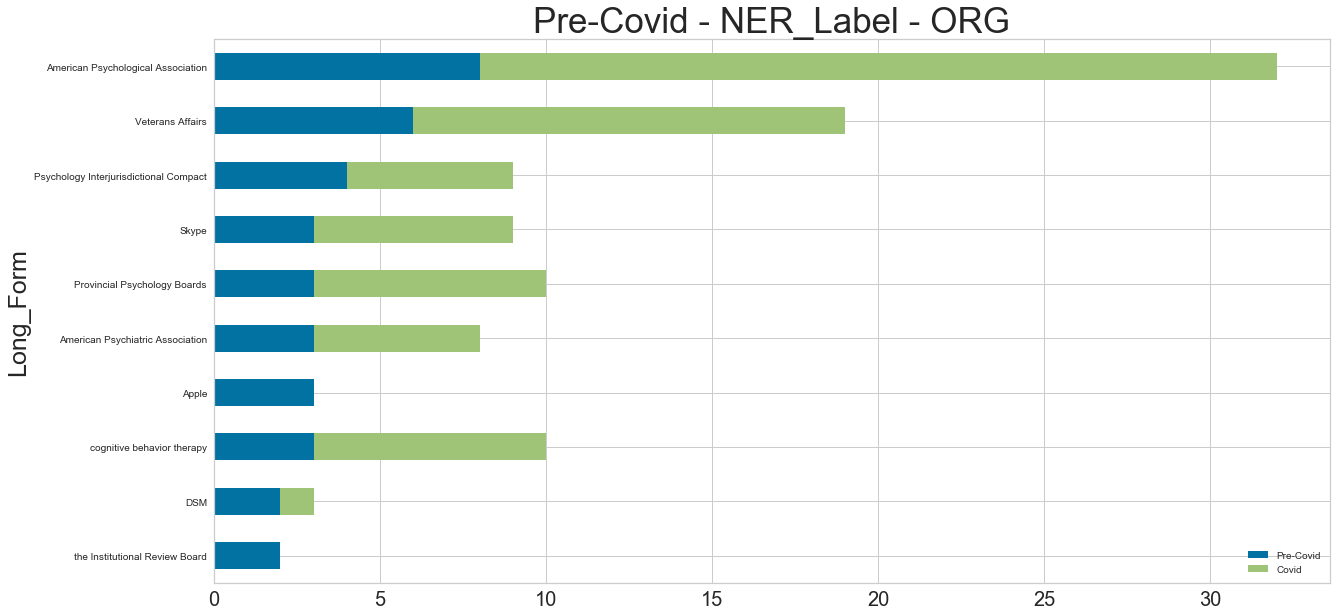

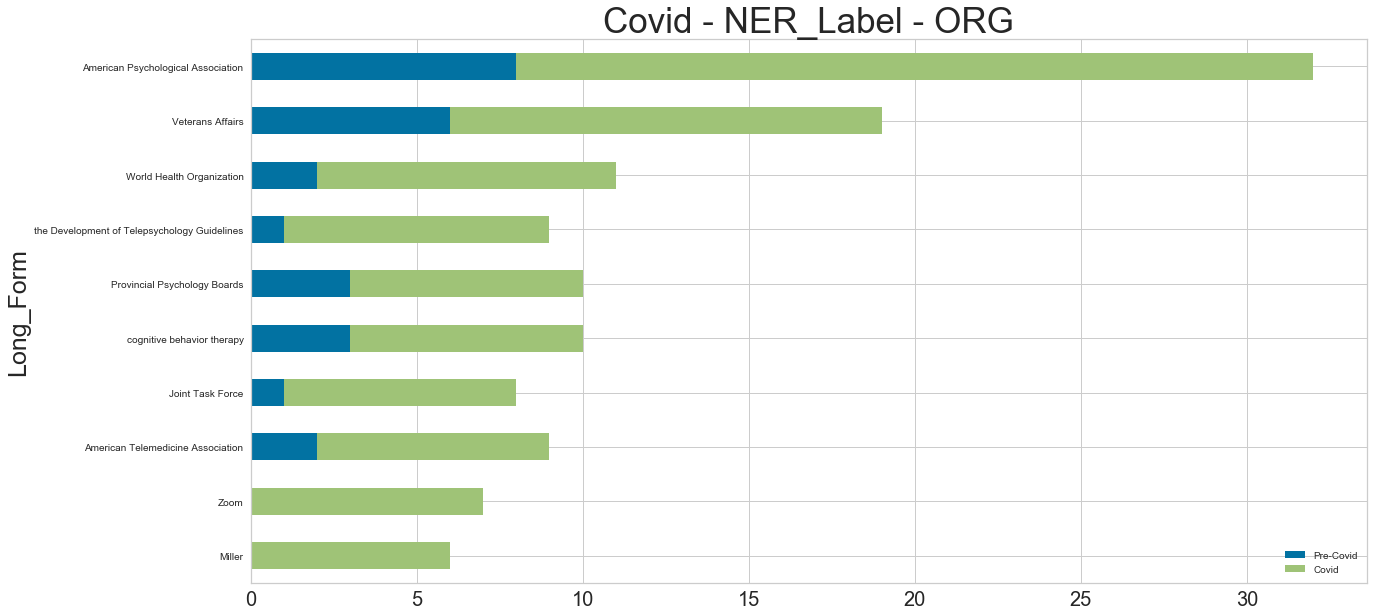

In [24]:
plot_compare(plot_by_time,"ORG")

# Take aways
<b> Same <b>
* Alot of change
* Many new names mentioned in the space
    
<b> Noticeable Movements <b>
    
<b> Rise <b>
    
* Chen is on the rise
* Wang is on the rise
* Cohen is on the rise
* Perle is on the rise
* Brooks is on the rise


    
<b> Most Notably Fall <b>
* Kramer is on the rise
* White is on the rise


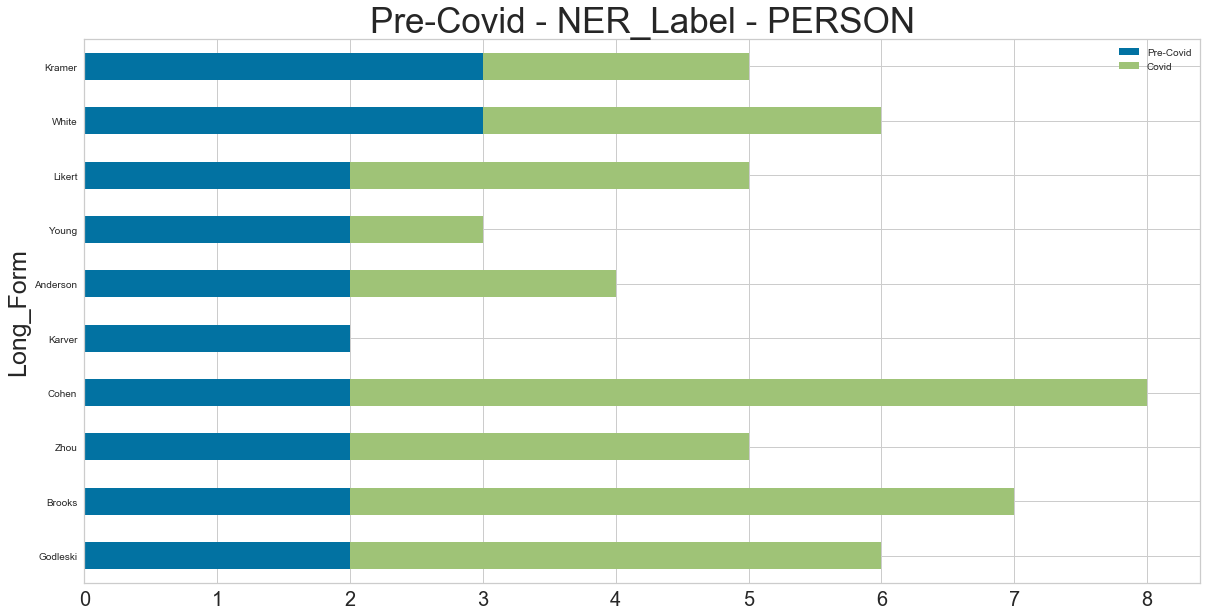

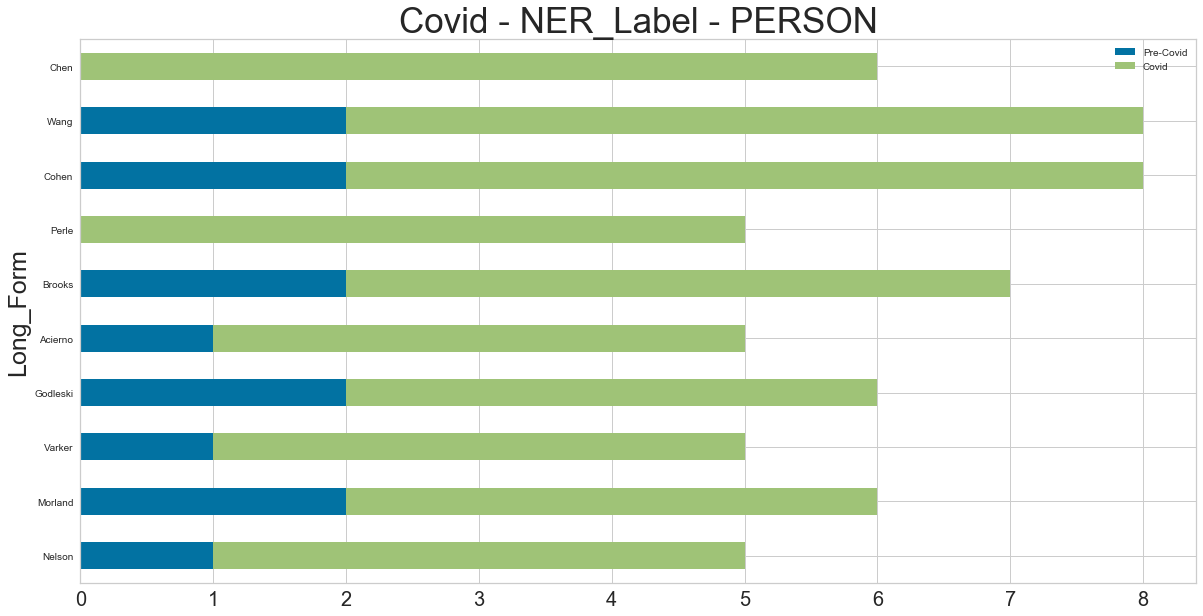

In [25]:
plot_compare(plot_by_time,"PERSON")